In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

<ipython-input-1-bc8c30725165>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


CAIXABANK MODEL PREDICTION

In [2]:
df_CABK = pd.read_csv("CABK.MC.csv")

In [3]:
df_CABK.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-12-20,3.750,3.759,3.700,3.755,2.472463,43110444.0
1,2013-12-23,3.756,3.789,3.725,3.789,2.494851,11507213.0
2,2013-12-24,3.740,3.769,3.735,3.745,2.465879,4981350.0
3,2013-12-27,3.730,3.795,3.710,3.774,2.484974,19022863.0
4,2013-12-30,3.783,3.799,3.750,3.782,2.490241,8422452.0


In [4]:
# Convert the 'Date' column to datetime if it's not already
df_CABK['Date'] = pd.to_datetime(df_CABK['Date'])

# Set the 'Date' column as the index
df_CABK.set_index('Date', inplace=True)

In [5]:
df_CABK.isnull().sum()

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [6]:
df_CABK = df_CABK.interpolate(method='linear', limit_direction='both', axis=0)

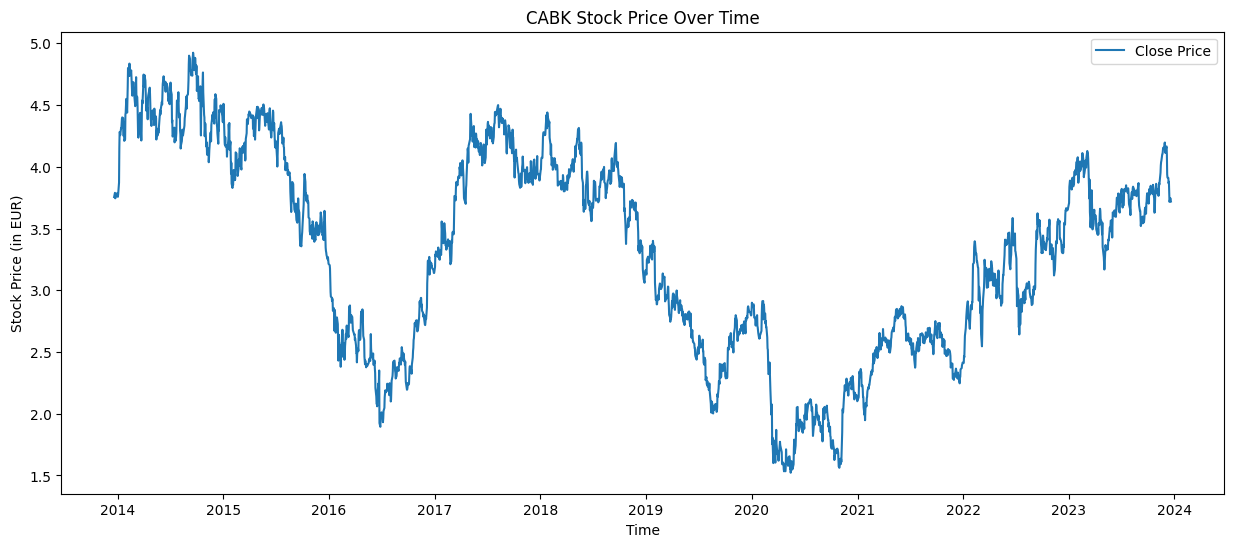

In [7]:
# Line plot of CABK
plt.figure(figsize=(15,6))
plt.plot(df_CABK.index, df_CABK['Close'], label='Close Price')

plt.title('CABK Stock Price Over Time')
plt.xlabel('Time')
plt.ylabel('Stock Price (in EUR)')
plt.legend()
plt.show()

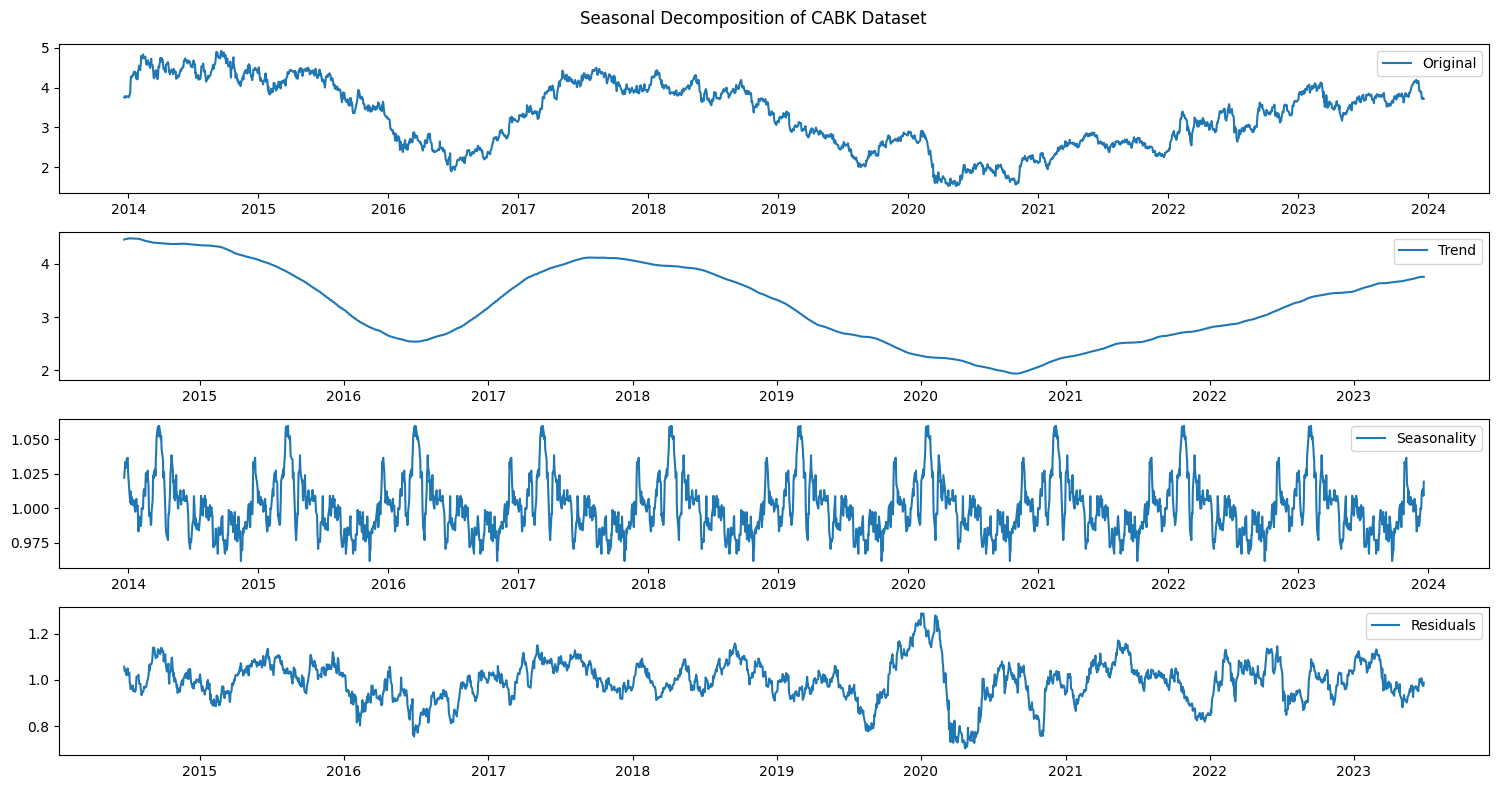

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Seasonal Decomposition for Training Data
decomposition_train = seasonal_decompose(df_CABK["Close"], model='multiplicative', period=252)

# Plotting the decomposition for Training Data
plt.figure(figsize=(15, 8))
plt.suptitle('Seasonal Decomposition of CABK Dataset')

plt.subplot(411)
plt.plot(df_CABK["Close"], label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(decomposition_train.trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(decomposition_train.seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(decomposition_train.resid, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [9]:
# Count the number of trading days in each year
trading_days_per_year = df_CABK.resample('Y').count()['Close']

# Calculate the average number of trading days
average_trading_days = trading_days_per_year.mean()

# Calculate daily volatility
daily_volatility = df_CABK['Close'].pct_change().std()

# Scale to annual volatility using the average number of trading days
annual_volatility = daily_volatility * (average_trading_days**0.5)

print("Annual Volatility:", annual_volatility)

Annual Volatility: 0.3274418467315031


In [10]:
from statsmodels.tsa.stattools import adfuller

# Apply the Augmented Dickey-Fuller test on the 'Close' price
result = adfuller(df_CABK['Close'])

# Print the results
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if result[1] > 0.05:
    print("The time series is likely non-stationary.")
else:
    print("The time series is likely stationary.")

ADF Statistic: -2.007226
p-value: 0.283414
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
The time series is likely non-stationary.


In [11]:
# Differencing the series
df_CABK_diff = df_CABK['Close'].diff().dropna()

# Apply the Augmented Dickey-Fuller test on the differenced series
result_diff = adfuller(df_CABK_diff)

# Print the results for the differenced series
print('ADF Statistic (Differenced Series): %f' % result_diff[0])
print('p-value (Differenced Series): %f' % result_diff[1])
print('Critical Values (Differenced Series):')
for key, value in result_diff[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if result_diff[1] > 0.05:
    print("The differenced time series is likely non-stationary.")
else:
    print("The differenced time series is likely stationary.")


ADF Statistic (Differenced Series): -50.559159
p-value (Differenced Series): 0.000000
Critical Values (Differenced Series):
	1%: -3.433
	5%: -2.863
	10%: -2.567
The differenced time series is likely stationary.


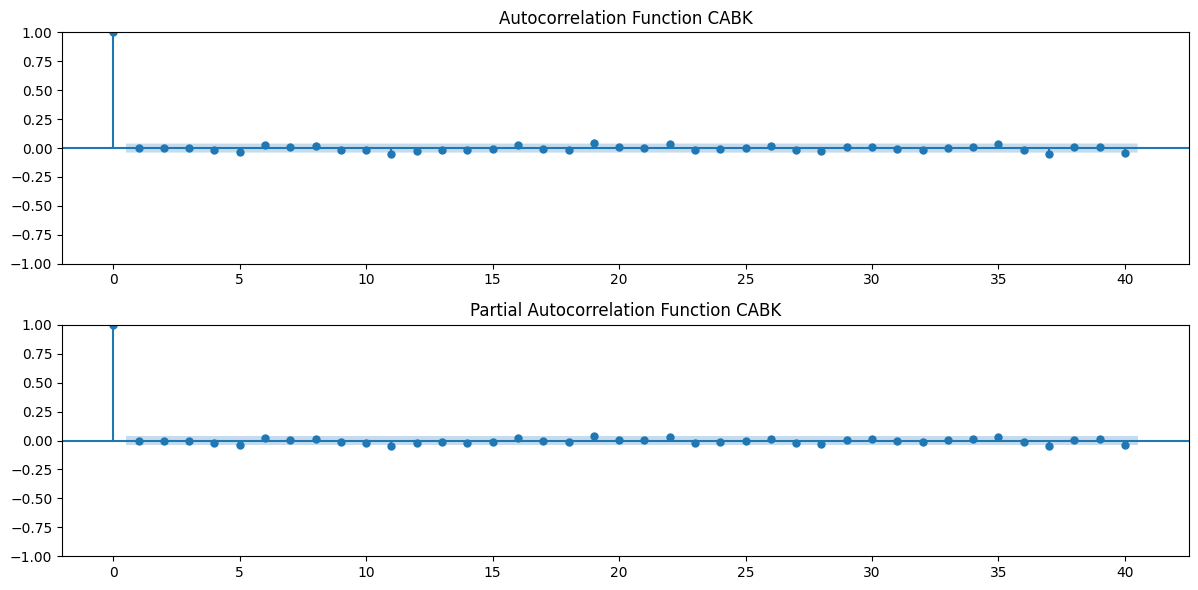

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
plt.figure(figsize=(12,6))
plt.subplot(211)
plot_acf(df_CABK_diff, ax=plt.gca(), lags=40)
plt.title("Autocorrelation Function CABK")

# Plot PACF
plt.subplot(212)
plot_pacf(df_CABK_diff, ax=plt.gca(), lags=40)
plt.title("Partial Autocorrelation Function CABK")

plt.tight_layout()
plt.show()

In [13]:
# Split the dataset into training and testing sets
train_data_CABK, test_data_CABK = df_CABK['Close'][0:int(len(df_CABK)*0.8)], df_CABK['Close'][int(len(df_CABK)*0.8):]

In [14]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.6 MB/s eta 0:00:00


In [15]:
from pmdarima import auto_arima

# Fit the model
auto_arima_model = auto_arima(train_data_CABK, start_p=1, start_q=1,
                              test='adf',
                              seasonal=False,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)

print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5392.202, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5396.034, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5394.259, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5394.270, Time=1.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5397.787, Time=0.44 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.018 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2048
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2699.893
Date:                Wed, 10 Jan 2024   AIC                          -5397.787
Time:                        16:52:00   BIC                          -5392.162
Sample:                             0   HQIC                         -5395.724
                               - 2048                                  

In [16]:
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Initialize variables
history = [x for x in train_data_CABK]  # Assuming train_data_CABK is your training dataset
model_predictions = []
N_test_observations = len(test_data_CABK)  # Assuming test_data_CABK is your test dataset

# Loop through each data point in the test set for predictions
for time_point in range(N_test_observations):
    # Create and fit ARIMA model
    model_arima = ARIMA(history, order=(0, 1, 0))
    model_fit = model_arima.fit()
    # Forecast the next point
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    # Get the true test value and append to history for next iteration
    true_test_value = test_data_CABK.iloc[time_point]
    history.append(true_test_value)

In [17]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Assuming test_data_CABK contains the true values and model_predictions contains your forecasts
# Calculate MSE
mse = mean_squared_error(test_data_CABK, model_predictions)
print('Mean Squared Error (MSE):', mse)

# Calculate RMSE
rmse = sqrt(mse)
print('Root Mean Squared Error (RMSE):', rmse)

# Calculate MAPE
mape = np.mean(np.abs((test_data_CABK - model_predictions) / test_data_CABK)) * 100
print('Mean Absolute Percentage Error (MAPE):', mape)

Mean Squared Error (MSE): 0.004655226562500002
Root Mean Squared Error (RMSE): 0.06822922073789207
Mean Absolute Percentage Error (MAPE): 1.5096037326430756


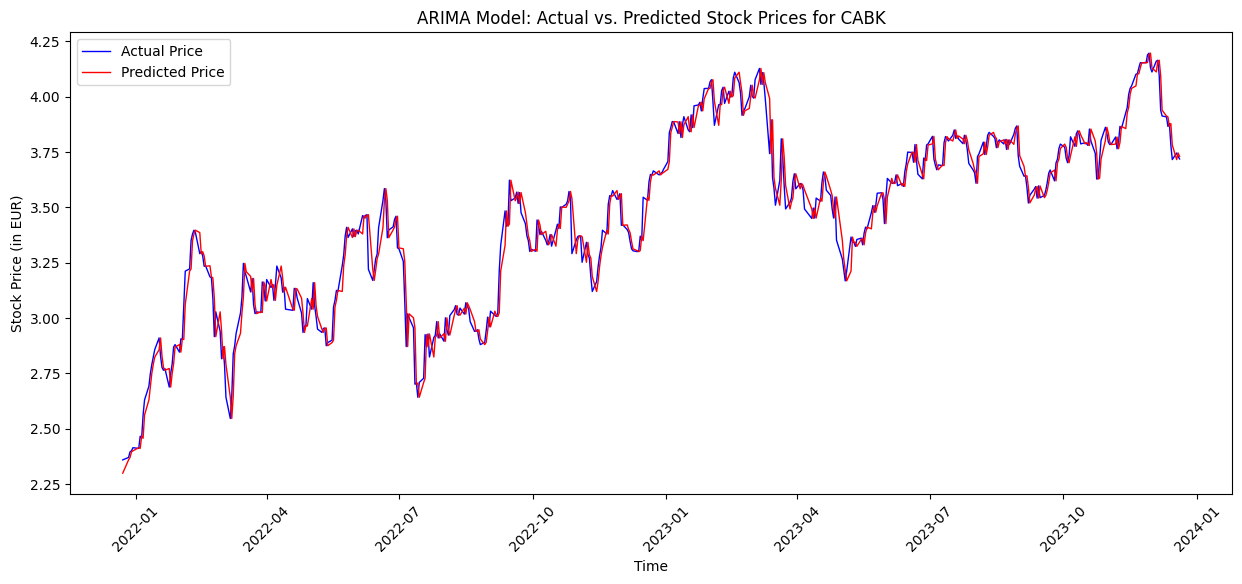

In [18]:
# Plot Predicted vs Actual price
test_set_range = df_CABK[int(len(df_CABK) * 0.8):].index

plt.figure(figsize=(15, 6))
plt.plot(test_set_range, test_data_CABK, color='blue', label='Actual Price', linewidth=1)
plt.plot(test_set_range, model_predictions, color='red', label='Predicted Price', linewidth=1)
plt.title('ARIMA Model: Actual vs. Predicted Stock Prices for CABK')
plt.xlabel('Time')
plt.ylabel('Stock Price (in EUR)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

BBVA BANK MODEL PREDICTION

In [19]:
df_BBVA = pd.read_csv("BBVA.MC.csv")

In [20]:
df_BBVA.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-12-20,8.726,8.800,8.656,8.784,5.305657,152109404.0
1,2013-12-23,8.786,8.829,8.739,8.829,5.332839,39792306.0
2,2013-12-24,8.819,8.865,8.806,8.865,5.354582,9512777.0
3,2013-12-27,8.838,8.970,8.838,8.970,5.418005,24693413.0
4,2013-12-30,8.970,9.000,8.896,8.950,5.405923,24247404.0


In [21]:
# Convert the 'Date' column to datetime
df_BBVA['Date'] = pd.to_datetime(df_BBVA['Date'])

# Set the 'Date' column as the index
df_BBVA.set_index('Date', inplace=True)

In [22]:
df_BBVA.isnull().sum()

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [23]:
df_BBVA = df_BBVA.interpolate(method='linear', limit_direction='both', axis=0)

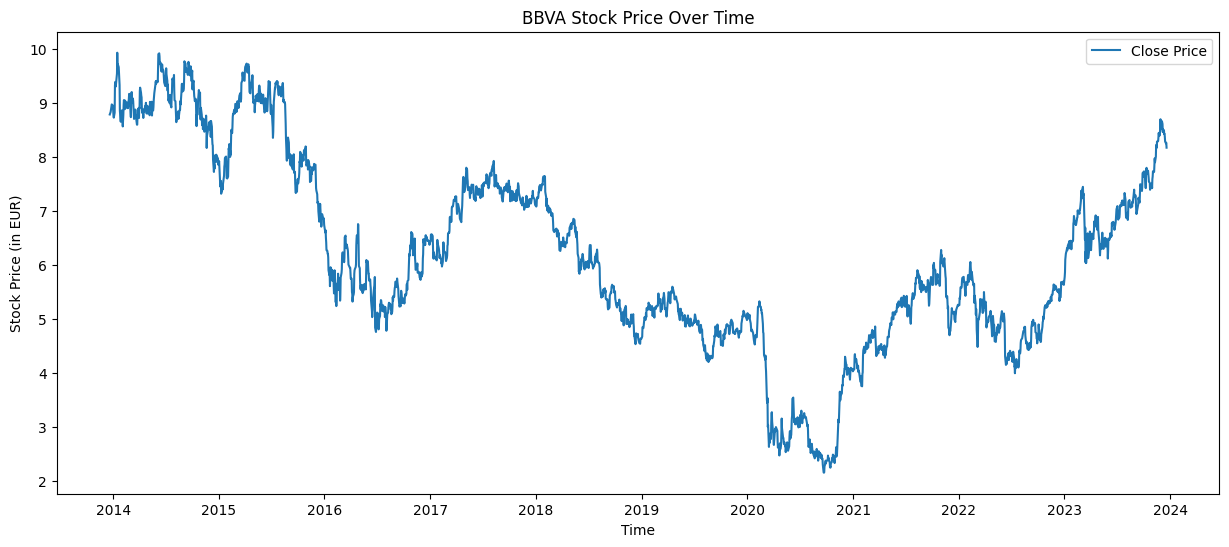

In [24]:
# Line plot of BBVA
plt.figure(figsize=(15,6))
plt.plot(df_BBVA.index, df_BBVA['Close'], label='Close Price')

plt.title('BBVA Stock Price Over Time')
plt.xlabel('Time')
plt.ylabel('Stock Price (in EUR)')
plt.legend()
plt.show()

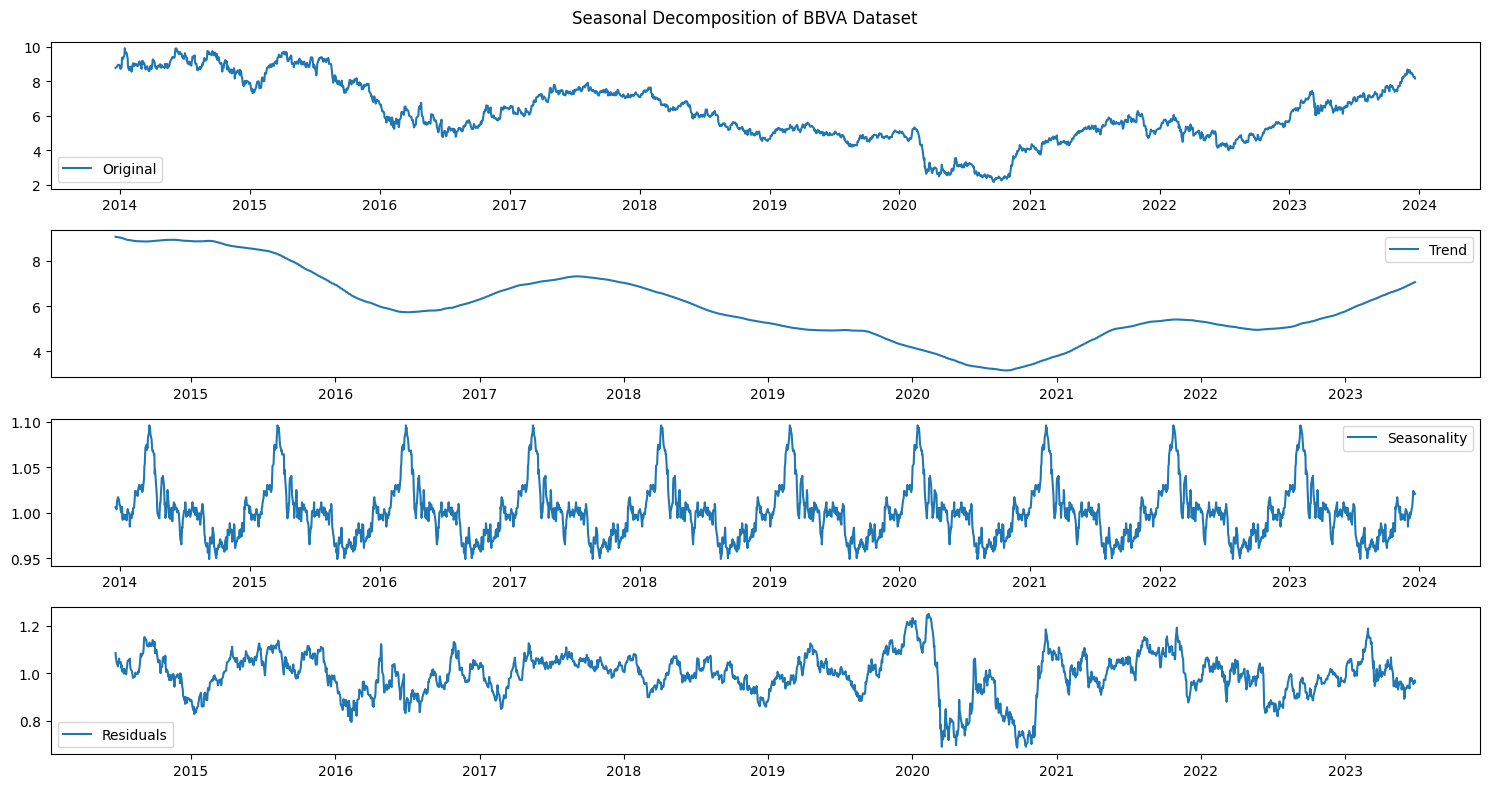

In [25]:
# Seasonal Decomposition for Training Data
decomposition_train = seasonal_decompose(df_BBVA["Close"], model='multiplicative', period=252)

# Plotting the decomposition for Training Data
plt.figure(figsize=(15, 8))
plt.suptitle('Seasonal Decomposition of BBVA Dataset')

plt.subplot(411)
plt.plot(df_BBVA["Close"], label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(decomposition_train.trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(decomposition_train.seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(decomposition_train.resid, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [26]:
# Count the number of trading days in each year
trading_days_per_year_BBVA = df_BBVA.resample('Y').count()['Close']

# Calculate the average number of trading days
average_trading_days = trading_days_per_year.mean()

# Calculate daily volatility
daily_volatility = df_BBVA['Close'].pct_change().std()

# Scale to annual volatility using the average number of trading days
annual_volatility = daily_volatility * (average_trading_days**0.5)

print("Annual Volatility:", annual_volatility)

Annual Volatility: 0.32205649678390486


In [27]:
# Apply the Augmented Dickey-Fuller test on the 'Close' price
result = adfuller(df_BBVA['Close'])

# Print the results
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if result[1] > 0.05:
    print("The time series is likely non-stationary.")
else:
    print("The time series is likely stationary.")

ADF Statistic: -1.789088
p-value: 0.385892
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
The time series is likely non-stationary.


In [28]:
# Differencing the series
df_BBVA_diff = df_BBVA['Close'].diff().dropna()

# Apply the Augmented Dickey-Fuller test on the differenced series
result_diff = adfuller(df_BBVA_diff)

# Print the results for the differenced series
print('ADF Statistic (Differenced Series): %f' % result_diff[0])
print('p-value (Differenced Series): %f' % result_diff[1])
print('Critical Values (Differenced Series):')
for key, value in result_diff[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if result_diff[1] > 0.05:
    print("The differenced time series is likely non-stationary.")
else:
    print("The differenced time series is likely stationary.")


ADF Statistic (Differenced Series): -49.584794
p-value (Differenced Series): 0.000000
Critical Values (Differenced Series):
	1%: -3.433
	5%: -2.863
	10%: -2.567
The differenced time series is likely stationary.


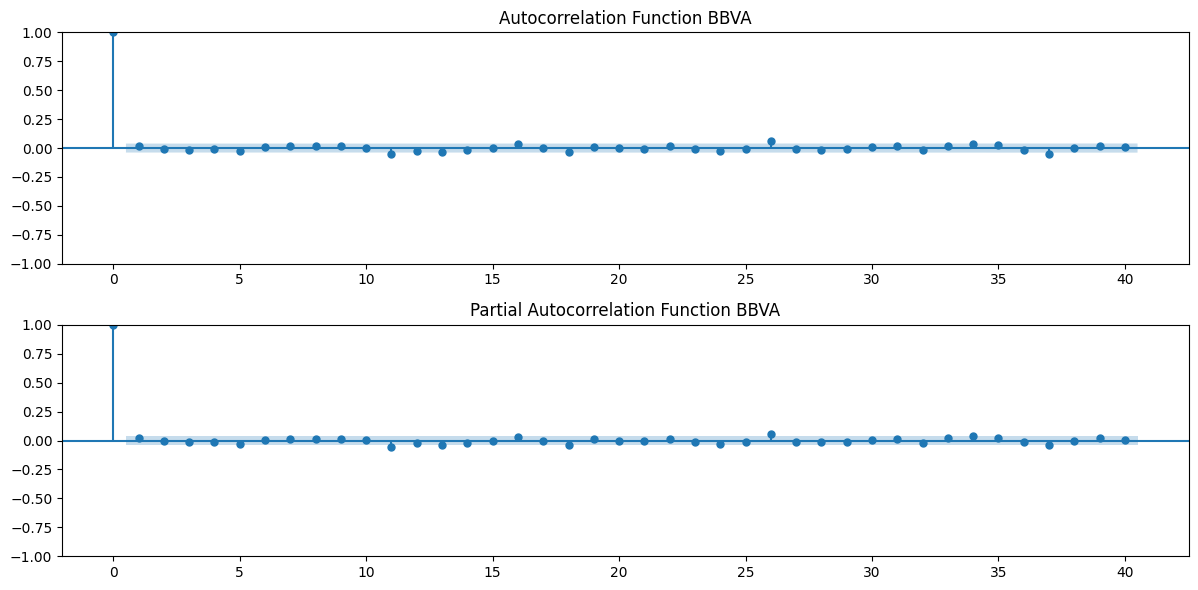

In [29]:
# Plot ACF
plt.figure(figsize=(12,6))
plt.subplot(211)
plot_acf(df_BBVA_diff, ax=plt.gca(), lags=40)
plt.title("Autocorrelation Function BBVA")

# Plot PACF
plt.subplot(212)
plot_pacf(df_BBVA_diff, ax=plt.gca(), lags=40)
plt.title("Partial Autocorrelation Function BBVA")

plt.tight_layout()
plt.show()

In [30]:
# Split the dataset into training and testing sets
train_data_BBVA, test_data_BBVA = df_BBVA['Close'][0:int(len(df_BBVA)*0.8)], df_BBVA['Close'][int(len(df_BBVA)*0.8):]

In [31]:
# Fit the model
auto_arima_model_BBVA = auto_arima(train_data_BBVA,
                              test='adf',
                              seasonal=False,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)

print(auto_arima_model_BBVA.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2992.618, Time=1.01 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2999.794, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2998.510, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2998.520, Time=1.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3001.302, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2996.606, Time=1.25 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 4.312 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2048
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1501.651
Date:                Wed, 10 Jan 2024   AIC                          -3001.302
Time:                        16:53:50   BIC                          -2995.678
Sample:                             0   HQIC                         -2999.240
    

In [32]:
# Ignore warnings
warnings.filterwarnings("ignore")

# Initialize variables
history_BBVA = [x for x in train_data_BBVA]
model_predictions_BBVA = []
N_test_observations_BBVA = len(test_data_BBVA)

# Loop through each data point in the test set for predictions
for time_point in range(N_test_observations_BBVA):
    # Create and fit ARIMA model
    model_arima = ARIMA(history_BBVA, order=(0, 1, 0))
    model_fit = model_arima.fit()
    # Forecast the next point
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions_BBVA.append(yhat)
    # Get the true test value and append to history for next iteration
    true_test_value = test_data_BBVA.iloc[time_point]
    history_BBVA.append(true_test_value)

In [33]:
# Calculate MSE
mse_BBVA = mean_squared_error(test_data_BBVA, model_predictions_BBVA)
print('Mean Squared Error (MSE):', mse_BBVA)

# Calculate RMSE
rmse_BBVA = sqrt(mse_BBVA)
print('Root Mean Squared Error (RMSE):', rmse_BBVA)

# Calculate MAPE
mape_BBVA = np.mean(np.abs((test_data_BBVA - model_predictions_BBVA) / test_data_BBVA)) * 100
print('Mean Absolute Percentage Error (MAPE):', mape_BBVA)

Mean Squared Error (MSE): 0.013060083984375002
Root Mean Squared Error (RMSE): 0.1142807244655677
Mean Absolute Percentage Error (MAPE): 1.4125563247539052


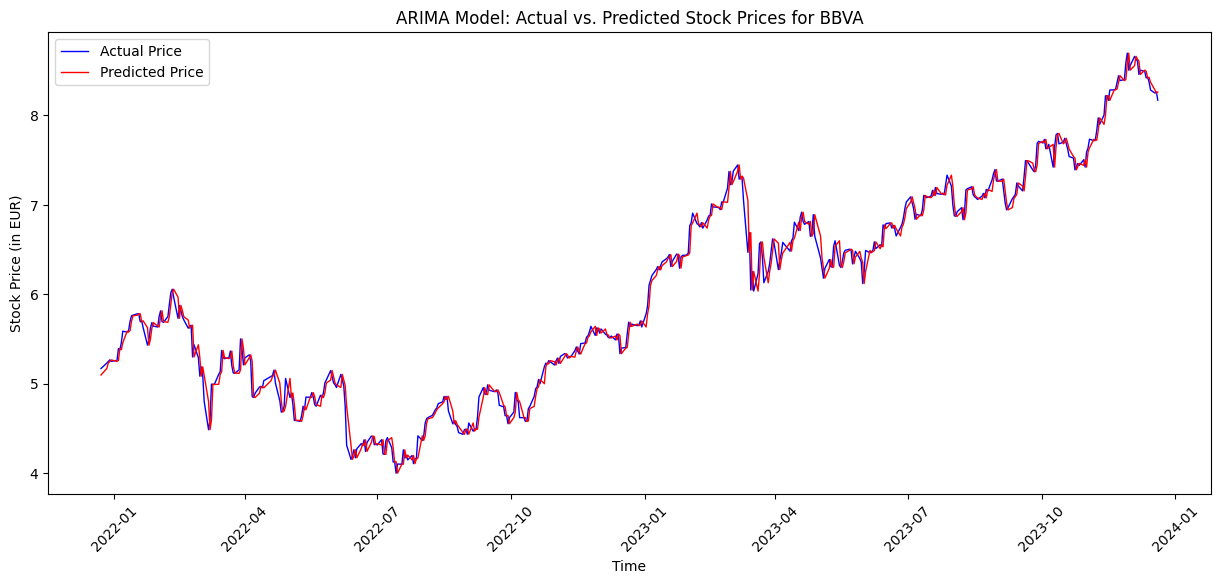

In [34]:
# Plot Predicted vs Actual price
test_set_range_BBVA = df_BBVA[int(len(df_BBVA) * 0.8):].index

plt.figure(figsize=(15, 6))
plt.plot(test_set_range_BBVA, test_data_BBVA, color='blue', label='Actual Price', linewidth=1)
plt.plot(test_set_range_BBVA, model_predictions_BBVA, color='red', label='Predicted Price', linewidth=1)
plt.title('ARIMA Model: Actual vs. Predicted Stock Prices for BBVA')
plt.xlabel('Time')
plt.ylabel('Stock Price (in EUR)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

SAN BANK MODEL PREDICTION

In [35]:
df_SAN = pd.read_csv("SAN.MC.csv")

In [36]:
df_SAN.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-12-20,5.982521,6.006085,5.917483,6.006085,3.700885,213163188.0
1,2013-12-23,6.011741,6.041903,5.959899,6.041903,3.722956,92522668.0
2,2013-12-24,6.049444,6.089032,6.027764,6.080549,3.746769,15662554.0
3,2013-12-27,6.098458,6.137103,6.070180,6.137103,3.781618,60934937.0
4,2013-12-30,6.144644,6.171978,6.106941,6.126735,3.775230,56726461.0


In [37]:
# Convert the 'Date' column to datetime
df_SAN['Date'] = pd.to_datetime(df_SAN['Date'])

# Set the 'Date' column as the index
df_SAN.set_index('Date', inplace=True)

In [38]:
df_SAN.isnull().sum()

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [39]:
df_SAN = df_SAN.interpolate(method='linear', limit_direction='both', axis=0)

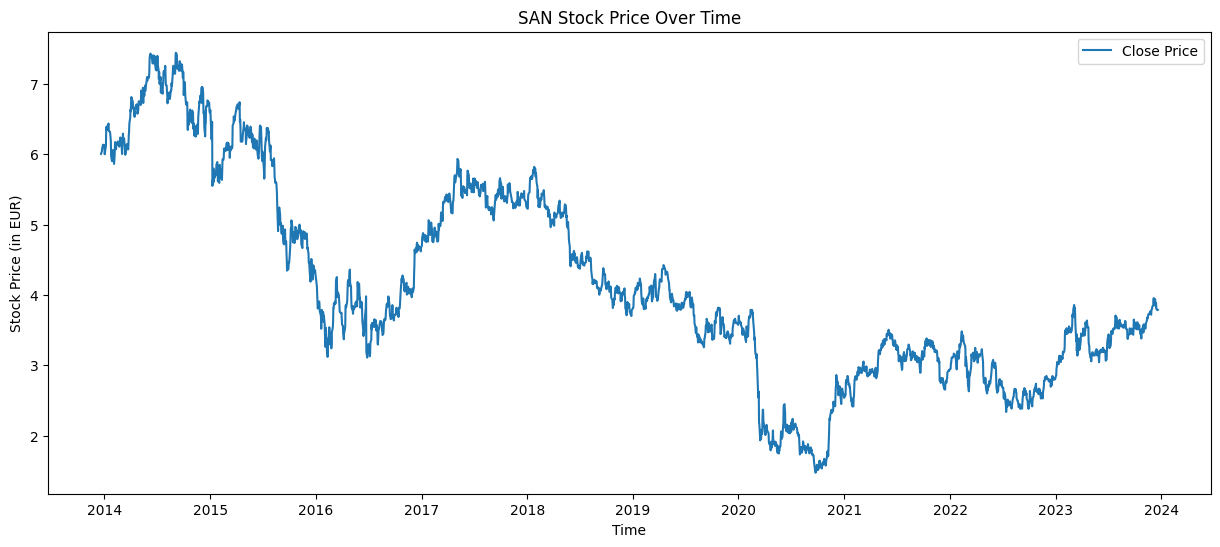

In [40]:
# Line plot of SAN
plt.figure(figsize=(15,6))
plt.plot(df_SAN.index, df_SAN['Close'], label='Close Price')

plt.title('SAN Stock Price Over Time')
plt.xlabel('Time')
plt.ylabel('Stock Price (in EUR)')
plt.legend()
plt.show()


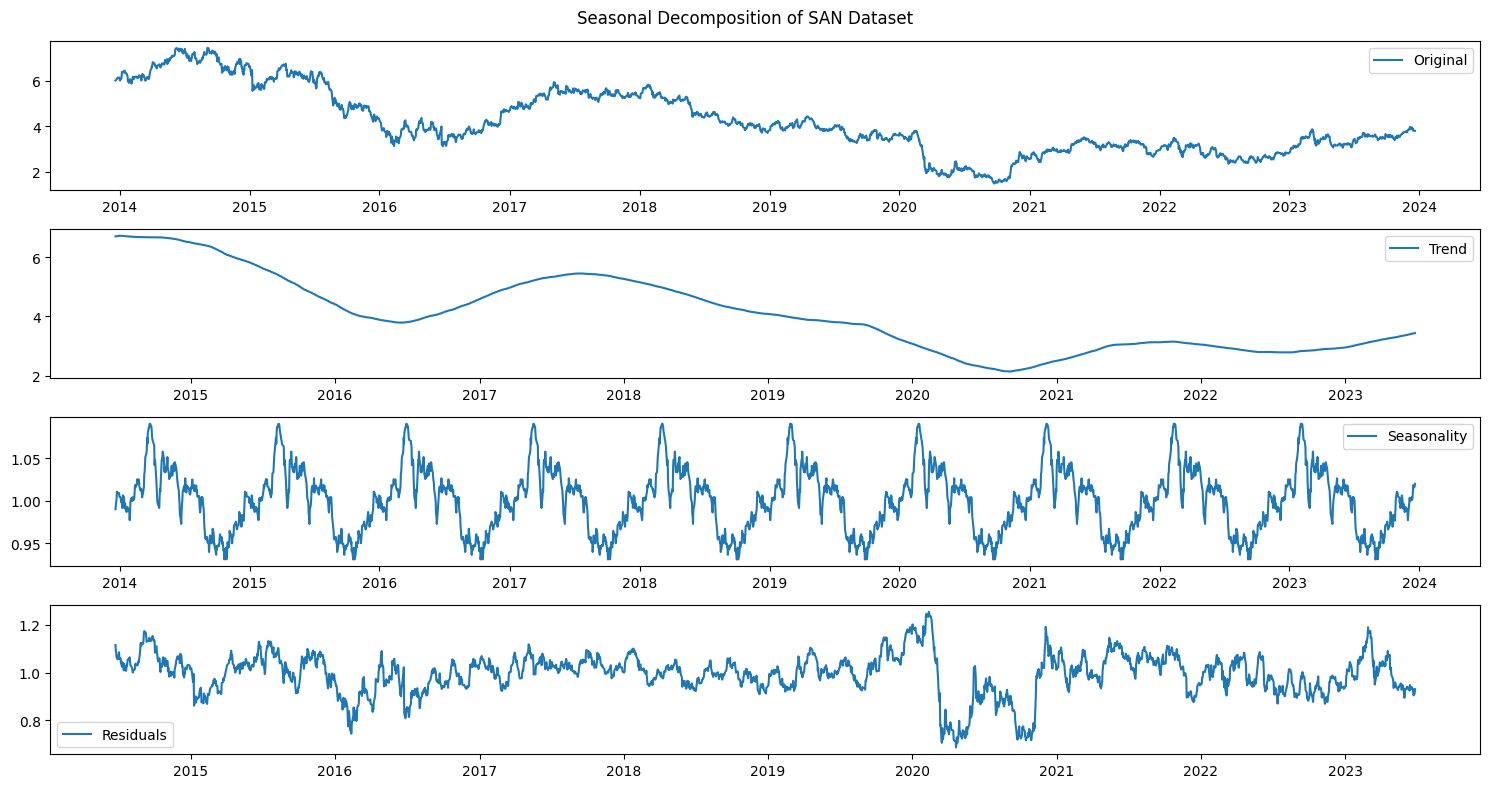

In [41]:
# Seasonal Decomposition for Training Data
decomposition_train_SAN = seasonal_decompose(df_SAN["Close"], model='multiplicative', period=252)

# Plotting the decomposition for Training Data
plt.figure(figsize=(15, 8))
plt.suptitle('Seasonal Decomposition of SAN Dataset')

plt.subplot(411)
plt.plot(df_SAN["Close"], label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(decomposition_train_SAN.trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(decomposition_train_SAN.seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(decomposition_train_SAN.resid, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [42]:
# Count the number of trading days in each year
trading_days_per_year_SAN = df_SAN.resample('Y').count()['Close']

# Calculate the average number of trading days
average_trading_days = trading_days_per_year_SAN.mean()

# Calculate daily volatility
daily_volatility_SAN = df_SAN['Close'].pct_change().std()

# Scale to annual volatility using the average number of trading days
annual_volatility_SAN = daily_volatility_SAN * (average_trading_days**0.5)

print("Annual Volatility:", annual_volatility_SAN)

Annual Volatility: 0.3254070089238461


In [43]:
# Apply the Augmented Dickey-Fuller test on the 'Close' price
result_SAN = adfuller(df_SAN['Close'])

# Print the results
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result_SAN[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if result_SAN[1] > 0.05:
    print("The time series is likely non-stationary.")
else:
    print("The time series is likely stationary.")

ADF Statistic: -1.789088
p-value: 0.385892
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
The time series is likely non-stationary.


In [44]:
# Differencing the series
df_SAN_diff = df_SAN['Close'].diff().dropna()

# Apply the Augmented Dickey-Fuller test on the differenced series
result_diff_SAN = adfuller(df_SAN_diff)

# Print the results for the differenced series
print('ADF Statistic (Differenced Series): %f' % result_diff_SAN[0])
print('p-value (Differenced Series): %f' % result_diff_SAN[1])
print('Critical Values (Differenced Series):')
for key, value in result_diff_SAN[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if result_diff_SAN[1] > 0.05:
    print("The differenced time series is likely non-stationary.")
else:
    print("The differenced time series is likely stationary.")


ADF Statistic (Differenced Series): -51.337314
p-value (Differenced Series): 0.000000
Critical Values (Differenced Series):
	1%: -3.433
	5%: -2.863
	10%: -2.567
The differenced time series is likely stationary.


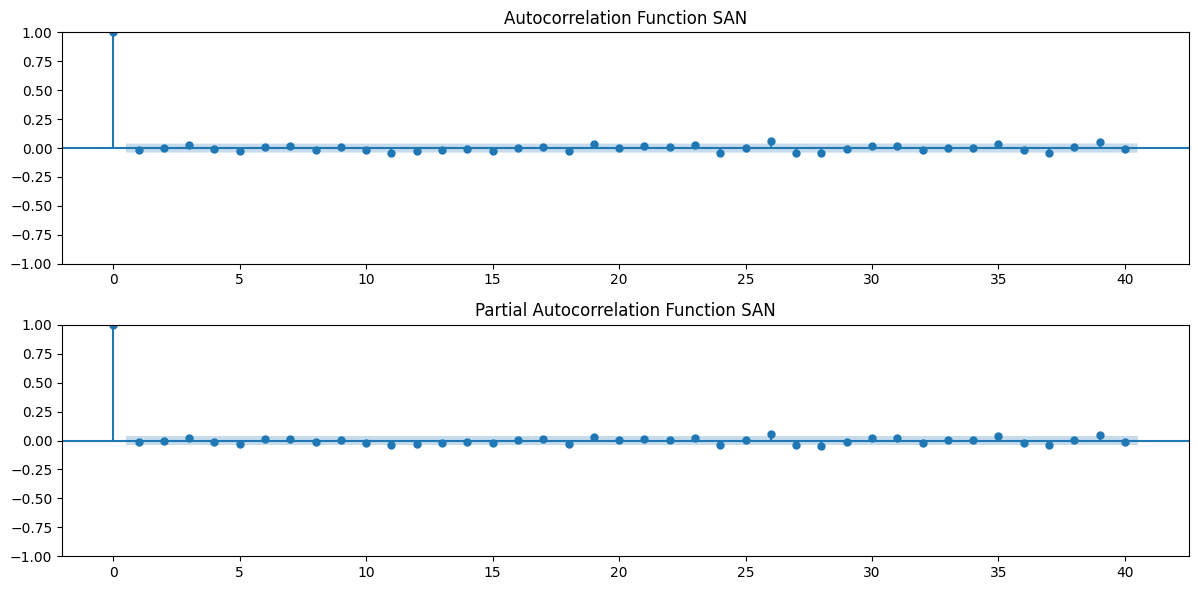

In [45]:
# Plot ACF
plt.figure(figsize=(12,6))
plt.subplot(211)
plot_acf(df_SAN_diff, ax=plt.gca(), lags=40)
plt.title("Autocorrelation Function SAN")

# Plot PACF
plt.subplot(212)
plot_pacf(df_SAN_diff, ax=plt.gca(), lags=40)
plt.title("Partial Autocorrelation Function SAN")

plt.tight_layout()
plt.show()

In [46]:
# Split the dataset into training and testing sets
train_data_SAN, test_data_SAN = df_SAN['Close'][0:int(len(df_SAN)*0.8)], df_SAN['Close'][int(len(df_SAN)*0.8):]

In [47]:
# Fit the model
auto_arima_model_SAN = auto_arima(train_data_SAN,
                              test='adf',
                              seasonal=False,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)

print(auto_arima_model_SAN.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4305.753, Time=0.98 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4312.860, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4311.660, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4311.671, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4314.160, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4309.537, Time=1.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 4.123 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2048
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2158.080
Date:                Wed, 10 Jan 2024   AIC                          -4314.160
Time:                        16:54:57   BIC                          -4308.536
Sample:                             0   HQIC                         -4312.097
    

In [48]:
# Ignore warnings
warnings.filterwarnings("ignore")

# Initialize variables
history_SAN = [x for x in train_data_SAN]
model_predictions_SAN = []
N_test_observations_SAN = len(test_data_SAN)

# Loop through each data point in the test set for predictions
for time_point in range(N_test_observations_SAN):
    # Create and fit ARIMA model
    model_arima = ARIMA(history_SAN, order=(0, 1, 0))
    model_fit = model_arima.fit()
    # Forecast the next point
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions_SAN.append(yhat)
    # Get the true test value and append to history for next iteration
    true_test_value = test_data_SAN.iloc[time_point]
    history_SAN.append(true_test_value)

In [49]:
# Calculate MSE
mse_SAN = mean_squared_error(test_data_SAN, model_predictions_SAN)
print('Mean Squared Error (MSE):', mse_SAN)

# Calculate RMSE
rmse_SAN = sqrt(mse_SAN)
print('Root Mean Squared Error (RMSE):', rmse_SAN)

# Calculate MAPE
mape_SAN = np.mean(np.abs((test_data_SAN - model_predictions_SAN) / test_data_SAN)) * 100
print('Mean Absolute Percentage Error (MAPE):', mape_SAN)


Mean Squared Error (MSE): 0.0038769868164062497
Root Mean Squared Error (RMSE): 0.062265454438285836
Mean Absolute Percentage Error (MAPE): 1.5178375055234479


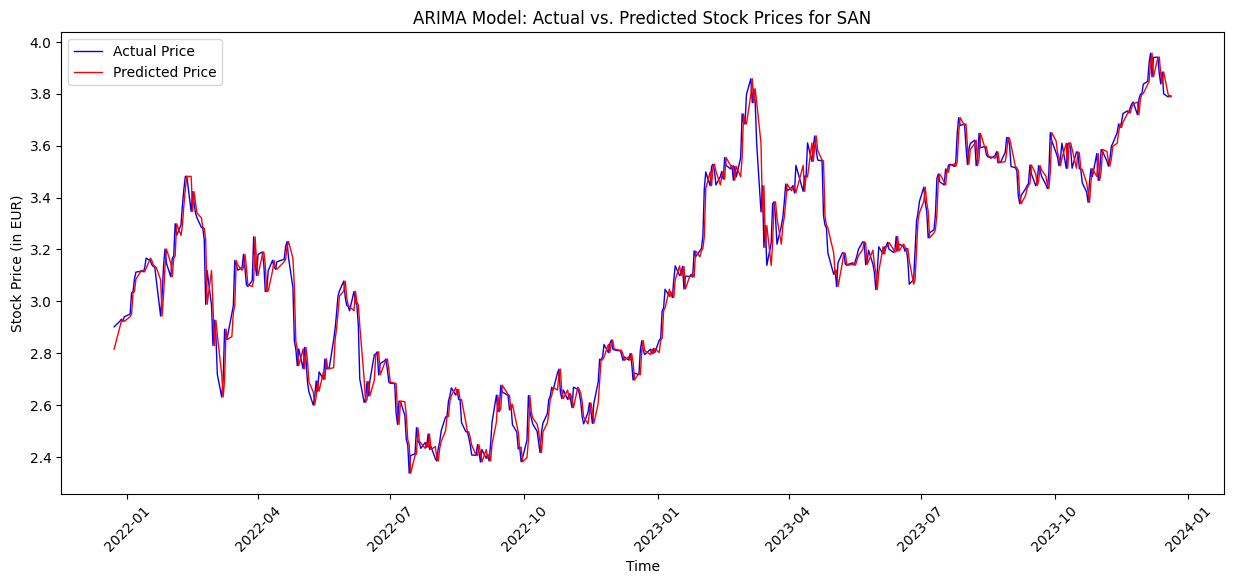

In [50]:
# Plot Predicted vs Actual price
test_set_range_SAN = df_SAN[int(len(df_SAN) * 0.8):].index

plt.figure(figsize=(15, 6))
plt.plot(test_set_range_SAN, test_data_SAN, color='blue', label='Actual Price', linewidth=1)
plt.plot(test_set_range_SAN, model_predictions_SAN, color='red', label='Predicted Price', linewidth=1)
plt.title('ARIMA Model: Actual vs. Predicted Stock Prices for SAN')
plt.xlabel('Time')
plt.ylabel('Stock Price (in EUR)')
plt.xticks(rotation=45)
plt.legend()
plt.show()